<a href="https://colab.research.google.com/github/CATS70/colab/blob/main/MSPR/batch_sam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%%capture
!pip install segment-anything


In [3]:
import torch
import os
import sys
import cv2
import numpy as np
import shutil
from PIL import Image
import re
from datetime import datetime
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator
import matplotlib.pyplot as plt
from google.colab import files
from tqdm.notebook import tqdm
import io
from google.colab import drive

# Montage de Google Drive pour accéder à tes fichiers
drive.mount('/content/drive')

# Définir le chemin vers ton dossier de travail sur Drive
work_dir = '/content/drive/MyDrive/MSPR/empreintes'

# Créer le dossier s'il n'existe pas
!mkdir -p {work_dir}
models_dir = '/content/drive/MyDrive/MSPR/models'
!mkdir -p {models_dir}

# Vérifier si le modèle existe déjà dans Drive
model_path = f"{models_dir}/sam_vit_h_4b8939.pth"
if not os.path.exists(model_path):
    print("Téléchargement du modèle SAM vers Google Drive...")
    !wget -O {model_path} https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
    print("Téléchargement terminé!")
else:
    print("Modèle SAM déjà présent dans Google Drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Modèle SAM déjà présent dans Google Drive


In [4]:
points_per_side = 32
min_area = 100
stability_thresh = 0.95
predict_iou = 0.85

# Configuration manuellement (ajuste selon tes besoins)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_type = 'vit_h'  # options: 'vit_h', 'vit_l', ou 'vit_b'
rename_files = True
prefix = 'empreinte_'

In [11]:
def rename_images(input_dir, prefix='empreinte_'):
    """
    Renomme toutes les images du répertoire avec un préfixe et un numéro séquentiel
    """
    # Extensions d'images valides
    valid_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.tif']

    # Récupérer la liste des fichiers d'images
    image_files = []
    for file in os.listdir(input_dir):
        file_path = os.path.join(input_dir, file)
        file_ext = os.path.splitext(file)[1].lower()
        if os.path.isfile(file_path) and file_ext in valid_extensions:
            image_files.append(file)

    # Trier les fichiers
    image_files.sort()

    # Créer un dictionnaire de correspondance
    name_mapping = {}

    # Date actuelle pour le préfixe
    date_str = datetime.now().strftime("%Y%m%d")

    # Renommer les fichiers
    for i, file in enumerate(image_files, 1):
        file_path = os.path.join(input_dir, file)
        file_ext = os.path.splitext(file)[1].lower()

        # Nouveau nom: prefix_YYYYMMDD_001.ext
        new_name = f"{prefix}{date_str}_{i:03d}{file_ext}"
        new_path = os.path.join(input_dir, new_name)

        # Vérifier si le fichier existe déjà
        if os.path.exists(new_path) and file != new_name:
            print(f"Attention: {new_name} existe déjà, génération d'un nom alternatif")
            new_name = f"{prefix}{date_str}_{i:03d}_bis{file_ext}"
            new_path = os.path.join(input_dir, new_name)

        # Renommer le fichier seulement s'il n'a pas déjà le bon format
        if not re.match(f"{prefix}\\d{{8}}_\\d{{3}}.*", file):
            try:
                os.rename(file_path, new_path)
                print(f"Renommé: {file} -> {new_name}")
                name_mapping[new_name] = file
            except Exception as e:
                print(f"Erreur lors du renommage de {file}: {e}")
                name_mapping[file] = file  # Garder le nom original en cas d'erreur
        else:
            print(f"Déjà au bon format: {file}")
            name_mapping[file] = file

    return name_mapping

def setup_sam(model_type, device):
    """
    Configure le modèle SAM
    """
    print(f"Configuration du modèle SAM ({model_type}) sur {device}...")

    # Map model type to expected filename
    model_filenames = {
        'vit_h': 'sam_vit_h_4b8939.pth',
        'vit_l': 'sam_vit_l_0b3195.pth',
        'vit_b': 'sam_vit_b_01ec64.pth'
    }

    # Chercher d'abord dans le répertoire courant, puis dans le dossier models
    sam_checkpoint = model_filenames[model_type]
    if not os.path.exists(sam_checkpoint):
        sam_checkpoint = os.path.join(models_dir, model_filenames[model_type])

    if not os.path.exists(sam_checkpoint):
        print(f"Erreur: Fichier de modèle {sam_checkpoint} introuvable.")
        return None

    sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
    sam.to(device=device)
    return sam

def create_mask_generator(sam):
    """
    Crée un générateur de masques automatique pour le modèle SAM
    """
    return SamAutomaticMaskGenerator(
        model=sam,
        points_per_side=points_per_side,
        pred_iou_thresh=predict_iou,
        stability_score_thresh=stability_thresh,
        crop_n_layers=1,
        crop_n_points_downscale_factor=2,
        min_mask_region_area=min_area,
    )

def has_parasites(image, threshold_regions=3, min_region_area=100):
    """
    Détermine si l'image RGB contient probablement des objets parasites
    en comptant le nombre de régions distinctes
    """
    # Convertir en niveaux de gris si nécessaire
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    else:
        gray = image

    # Appliquer un flou pour réduire le bruit
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Binarisation avec Otsu
    _, binary = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Analyse des composantes connexes
    nb_components, labels, stats, _ = cv2.connectedComponentsWithStats(binary, connectivity=8)

    # Compter les régions significatives
    significant_regions = 0
    for i in range(1, nb_components):  # Ignorer le fond (label 0)
        if stats[i, cv2.CC_STAT_AREA] >= min_region_area:
            significant_regions += 1

    # Calculer également l'écart-type de l'image comme mesure de complexité
    std_dev = np.std(gray)
    complexity = std_dev > 50  # Seuil à ajuster selon vos images

    return significant_regions > threshold_regions or complexity

def segment_image(image, mask_generator):
    """
    Segmente l'image en utilisant SAM
    """
    try:
        masks_raw = mask_generator.generate(image)
        if not masks_raw:
            return None

        # Trier les masques par surface et prendre le premier (le plus grand)
        sorted_masks = sorted(masks_raw, key=(lambda x: x['area']), reverse=True)
        return sorted_masks[0] if sorted_masks else None

    except RuntimeError as e:
        error_type = str(type(e))
        error_str = error_type.lstrip("<class '").rstrip("'>")
        print(f"{error_str}: {e}")
        return None

def prepare_output_images(image, mask):
    """
    Prépare les images de sortie à partir du masque
    """
    # Obtenir l'image RGB pour le traitement
    image_array = np.asarray(image)

    # Créer le masque en niveaux de gris
    bw_mask = np.asarray(image).copy()
    bw_mask[mask["segmentation"] == 1] = (255, 255, 255)
    bw_mask[mask["segmentation"] != 1] = (0, 0, 0)
    bw_mask_pil = Image.fromarray(bw_mask).convert('L')

    # Créer l'image masquée
    result_pil = Image.fromarray(image_array)
    result_pil.putalpha(bw_mask_pil.copy())

    # Créer l'image recadrée
    cropped_pil = crop_alpha(result_pil, bw_mask_pil, mask["bbox"])

    return bw_mask_pil, result_pil, cropped_pil

def crop_alpha(image_in, alpha, bbox):
    """
    Recadre l'image selon la boîte englobante
    """
    out = image_in.copy()
    out.putalpha(alpha.copy())
    out = out.crop((bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1] + bbox[3]))
    return out

def visualize_results(image_path, mask_path, masked_path, cropped_path):
    """
    Affiche les résultats de la segmentation pour une image
    """
    fig, axs = plt.subplots(1, 4, figsize=(20, 5))

    # Image originale
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    axs[0].imshow(image_rgb)
    axs[0].set_title('Image originale')
    axs[0].axis('off')

    # Masque
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    axs[1].imshow(mask, cmap='gray')
    axs[1].set_title('Masque')
    axs[1].axis('off')

    # Image masquée
    masked = Image.open(masked_path)
    axs[2].imshow(masked)
    axs[2].set_title('Image masquée')
    axs[2].axis('off')

    # Image recadrée
    cropped = Image.open(cropped_path)
    axs[3].imshow(cropped)
    axs[3].set_title('Image recadrée')
    axs[3].axis('off')

    plt.tight_layout()
    plt.show()

In [6]:
def upload_images_to_colab(target_dir=None):
    """
    Permet à l'utilisateur de télécharger des images vers Colab
    """
    if target_dir is None:
        target_dir = os.path.join(os.getcwd(), 'uploaded_images')

    # Créer le répertoire s'il n'existe pas
    os.makedirs(target_dir, exist_ok=True)

    # Télécharger les fichiers
    uploaded = files.upload()

    # Déplacer les fichiers vers le répertoire cible
    for filename, content in uploaded.items():
        with open(os.path.join(target_dir, filename), 'wb') as f:
            f.write(content)

    print(f"{len(uploaded)} fichiers téléchargés vers {target_dir}")
    return target_dir

In [7]:
def process_directory(input_dir, sam, device, mask_generator=None):
    """
    Traite toutes les images du répertoire
    """
    if mask_generator is None:
        mask_generator = create_mask_generator(sam)

    # Créer le répertoire de sorties
    mask_dir = os.path.join(input_dir, "masks")
    os.makedirs(mask_dir, exist_ok=True)

    # Obtenir tous les fichiers du répertoire
    all_files = os.listdir(input_dir)
    files = [f for f in all_files if os.path.isfile(os.path.join(input_dir, f))]

    # Extensions d'images valides
    valid_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.tif']

    # Filtrer uniquement les fichiers image
    image_files = [f for f in files if any(f.lower().endswith(ext) for ext in valid_extensions)]

    processed_count = 0
    skipped_count = 0
    clean_count = 0  # Compteur pour les images propres

    print(f"Traitement de {len(image_files)} images...")

    # Utiliser tqdm pour afficher une barre de progression
    for file in tqdm(image_files):
        file_path = os.path.join(input_dir, file)

        try:
            # Charger l'image
            image = cv2.imread(file_path)
            if image is None:
                print(f"  Erreur: Impossible de lire l'image {file}")
                skipped_count += 1
                continue

            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            # Vérifier si l'image contient des parasites
            if not has_parasites(image_rgb):
                # Pour les images propres, créer un masque plein (tout blanc)
                filename_base = os.path.splitext(file)[0]

                # Créer un masque blanc plein (tout l'objet est conservé)
                height, width = image.shape[:2]
                full_mask = np.ones((height, width), dtype=np.uint8) * 255
                full_mask_pil = Image.fromarray(full_mask)

                # Sauvegarder le masque plein
                mask_path = os.path.join(mask_dir, f"{filename_base}_mask1.png")
                full_mask_pil.save(mask_path)

                # Pour l'image masquée, c'est simplement l'image originale
                img_pil = Image.fromarray(image_rgb)
                masked_path = os.path.join(mask_dir, f"{filename_base}_masked.png")
                img_pil.save(masked_path)

                # Pour l'image cropée, on peut simplement utiliser l'original aussi
                cropped_path = os.path.join(mask_dir, f"{filename_base}_cropped.png")
                img_pil.save(cropped_path)

                clean_count += 1
                continue

            # Segmenter l'image (seulement pour les images avec parasites)
            mask = segment_image(image_rgb, mask_generator)

            if mask is None:
                print(f"  Attention: Aucun masque généré pour {file}")
                skipped_count += 1
                continue

            # Préparer les images de sortie
            bw_mask, masked_image, cropped_image = prepare_output_images(image_rgb, mask)

            # Sauvegarder les sorties
            filename_base = os.path.splitext(file)[0]

            # Sauvegarder l'image du masque
            mask_path = os.path.join(mask_dir, f"{filename_base}_mask1.png")
            bw_mask.save(mask_path)

            # Sauvegarder l'image masquée
            masked_path = os.path.join(mask_dir, f"{filename_base}_masked.png")
            masked_image.save(masked_path)

            # Sauvegarder l'image recadrée
            cropped_path = os.path.join(mask_dir, f"{filename_base}_cropped.png")
            cropped_image.save(cropped_path)

            processed_count += 1

        except Exception as e:
            print(f"  Erreur lors du traitement de {file}: {str(e)}")
            skipped_count += 1

    print(f"\nTraitement terminé.")
    print(f"Images propres (sans parasites): {clean_count}")
    print(f"Images traitées avec SAM: {processed_count}")
    print(f"Images ignorées: {skipped_count}")

    return mask_dir

Renommage des images...
Déjà au bon format: empreinte_20250227_001.jpg
Déjà au bon format: empreinte_20250227_002.jpg
Déjà au bon format: empreinte_20250227_003.jpg
Déjà au bon format: empreinte_20250227_004.jpg
Déjà au bon format: empreinte_20250227_005.jpeg
Déjà au bon format: empreinte_20250227_006.jpg
Déjà au bon format: empreinte_20250227_007.jpeg
Déjà au bon format: empreinte_20250227_008.jpg
Déjà au bon format: empreinte_20250227_009.jpeg
Déjà au bon format: empreinte_20250227_010.jpg
Déjà au bon format: empreinte_20250227_011.jpeg
Déjà au bon format: empreinte_20250227_012.jpg
Déjà au bon format: empreinte_20250227_013.jpg
Déjà au bon format: empreinte_20250227_014.jpg
Déjà au bon format: empreinte_20250227_015.jpg
Déjà au bon format: empreinte_20250227_016.jpg
Déjà au bon format: empreinte_20250227_017.jpg
Déjà au bon format: empreinte_20250227_018.jpeg
Déjà au bon format: empreinte_20250227_019.jpg
19 images traitées.
Configuration du modèle SAM (vit_h) sur cuda...


/usr/local/lib/python3.11/dist-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


Traitement de 19 images...


  0%|          | 0/19 [00:00<?, ?it/s]


Traitement terminé.
Images propres (sans parasites): 0
Images traitées avec SAM: 19
Images ignorées: 0


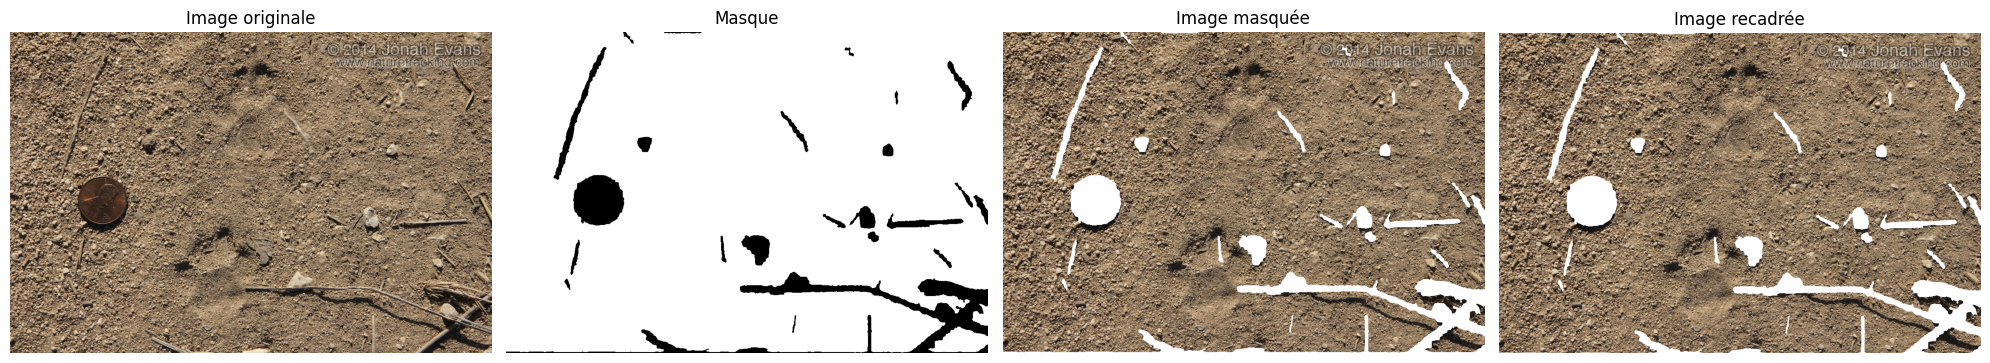

In [12]:

# Télécharger des images
input_dir = '/content/drive/MyDrive/MSPR/empreintes/Felis silvestris' #upload_images_to_colab('uploaded_images')

# Renommer les images si demandé
if rename_files:
    print("Renommage des images...")
    rename_mapping = rename_images(input_dir, prefix)
    print(f"{len(rename_mapping)} images traitées.")

# Configurer le modèle SAM
sam = setup_sam(model_type, device)
if sam is None:
    print("Erreur lors du chargement du modèle.")
else:
    # Traiter le répertoire
    mask_dir = process_directory(input_dir, sam, device)

    # Visualiser un exemple de résultat
    example_files = [f for f in os.listdir(input_dir) if any(f.lower().endswith(ext) for ext in ['.jpg', '.jpeg', '.png'])]
    if example_files:
        example = example_files[0]
        example_base = os.path.splitext(example)[0]
        visualize_results(
            os.path.join(input_dir, example),
            os.path.join(mask_dir, f"{example_base}_mask1.png"),
            os.path.join(mask_dir, f"{example_base}_masked.png"),
            os.path.join(mask_dir, f"{example_base}_cropped.png")
        )


In [ ]:
def rotate_images(input_dir, angles=None, subfolder='rotated'):
    """
    Fait pivoter les images d'un répertoire selon les angles spécifiés

    Args:
        input_dir: Répertoire contenant les images
        angles: Liste des angles de rotation en degrés (par défaut [90, 180, 270])
        subfolder: Nom du sous-dossier de sortie
    """
    if angles is None:
        angles = [90, 180, 270]

    # Créer le répertoire de sortie
    output_dir = os.path.join(input_dir, subfolder)
    os.makedirs(output_dir, exist_ok=True)

    # Extensions d'images valides
    valid_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.tif']

    # Obtenir tous les fichiers du répertoire
    files = [f for f in os.listdir(input_dir)
             if os.path.isfile(os.path.join(input_dir, f))
             and any(f.lower().endswith(ext) for ext in valid_extensions)]

    rotated_count = 0

    # Traiter chaque image
    for file in tqdm(files):
        file_path = os.path.join(input_dir, file)
        file_name, file_ext = os.path.splitext(file)

        try:
            # Ouvrir l'image
            img = Image.open(file_path)

            # Faire pivoter selon chaque angle
            for angle in angles:
                # Faire pivoter l'image
                rotated_img = img.rotate(angle, expand=True)

                # Sauvegarder l'image pivotée
                output_path = os.path.join(output_dir, f"{file_name}_rot{angle}{file_ext}")
                rotated_img.save(output_path)
                rotated_count += 1

        except Exception as e:
            print(f"Erreur lors de la rotation de {file}: {e}")

    print(f"Rotation terminée. {rotated_count} images créées dans {output_dir}")
    return output_dir

In [ ]:
def adjust_contrast_brightness(input_dir, contrast_factors=None, brightness_factors=None, subfolder='adjusted'):
    """
    Ajuste le contraste et la luminosité des images

    Args:
        input_dir: Répertoire contenant les images
        contrast_factors: Liste des facteurs de contraste (par défaut [0.8, 1.2])
        brightness_factors: Liste des facteurs de luminosité (par défaut [-20, 20])
        subfolder: Nom du sous-dossier de sortie
    """
    if contrast_factors is None:
        contrast_factors = [0.8, 1.2]
    if brightness_factors is None:
        brightness_factors = [-20, 20]

    # Créer le répertoire de sortie
    output_dir = os.path.join(input_dir, subfolder)
    os.makedirs(output_dir, exist_ok=True)

    # Extensions d'images valides
    valid_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.tif']

    # Obtenir tous les fichiers du répertoire
    files = [f for f in os.listdir(input_dir)
             if os.path.isfile(os.path.join(input_dir, f))
             and any(f.lower().endswith(ext) for ext in valid_extensions)]

    adjusted_count = 0

    # Traiter chaque image
    for file in tqdm(files):
        file_path = os.path.join(input_dir, file)
        file_name, file_ext = os.path.splitext(file)

        try:
            # Ouvrir l'image avec OpenCV
            img = cv2.imread(file_path)

            # Pour chaque combinaison de contraste et luminosité
            for contrast in contrast_factors:
                for brightness in brightness_factors:
                    # Appliquer le contraste
                    adjusted = img.copy() * contrast

                    # Appliquer la luminosité
                    adjusted = adjusted + brightness

                    # S'assurer que les valeurs sont dans [0, 255]
                    adjusted = np.clip(adjusted, 0, 255).astype(np.uint8)

                    # Sauvegarder l'image ajustée
                    output_path = os.path.join(output_dir, f"{file_name}_c{int(contrast*100)}_b{brightness}{file_ext}")
                    cv2.imwrite(output_path, adjusted)
                    adjusted_count += 1

        except Exception as e:
            print(f"Erreur lors de l'ajustement de {file}: {e}")

    print(f"Ajustement terminé. {adjusted_count} images créées dans {output_dir}")
    return output_dir

In [ ]:
"""
# Définir le répertoire d'entrée (masques créés précédemment)
mask_dir = os.path.join(input_dir, "masks")

# Faire pivoter les images
rotate_dir = rotate_images(mask_dir, angles=[45, 90, 135, 180, 225, 270, 315])

# Ajuster le contraste et la luminosité
adjust_dir = adjust_contrast_brightness(mask_dir,
                                      contrast_factors=[0.7, 0.85, 1.15, 1.3],
                                      brightness_factors=[-30, -15, 15, 30])
"""